# Data Pre-Processing and Exploratory Data Analysis

### Import the Data

Import all libraries needed for the project, and import the data into a dataframe. 

In [25]:
# Importing needed libraries 
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor

# For scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# Import the dataset
dataset = pd.read_csv("data/train.csv")
# Create dataframe
df = pd.DataFrame(dataset)
# Check dataset
df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


### Remove Missing Values 

Remove the missing values 

In [5]:
# 1. Remove missing values: All our missing data is marked with -1, so remove every row that has a -1 in it: 
df = df.replace(-1, np.NaN) # replace the -1 values with NaN, since they indicate missing data
df.dropna(inplace=True)

### Split into Train and Testing Sets

In [6]:
# 2. Split into train and testing data 
X = df.iloc[:, 2:] # dropping the id and target columns
y = df["target"] # just the target column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Removing Outliers

Removes all outliers from `X_train` and `y_train`. 

In [7]:
# 3. Remove outliers: It depends on what you exactly need for your use-case, but if you remove outliers after standardizing, the resulting data won't be standardized anymore (if many outliers are removed, standard deviation could become considerably smaller than 1)
# identify outliers in the training dataset
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X_train) # Label is 1 for an inlier and -1 for an outlier
# select all rows that are not outliers
inlier_indexes = y_pred == 1

# Remove from X_train and y_train
X_train, y_train = X_train[inlier_indexes], y_train[inlier_indexes]

### Scaling the Data

In [35]:
def scale_data(X_train, X_test, type='sta'):
    """
    This function gets the train and test data, and scales it. 

    Parameters:
    - X_train: The training data 
    - y_train: The labels of the training data 
    - X_test: The testing data 
    - y_test: The labels of the testing data 
    - type: The type of scaler to use, either `mm` for MinMax Scaling or `sta` for Standard Scaling.

    Returns:
    X_train, y_train, X_test, y_test scaled

    Example:
    >>> X_train, y_train, X_test, y_test = scale_data(scaling='mm')
    """
    
    if (type == 'mm'):
        mm = MinMaxScaler()
        X_train_scaled = mm.fit_transform(X_train)
        X_test_scaled = mm.fit_transform(X_test)
    elif (type == 'sta'):
        sta = StandardScaler()
        X_train_scaled = sta.fit_transform(X_train)
        X_test_scaled = sta.fit_transform(X_test)
    else: 
        return "No correct scaling method."
    
    print("Scaled data, size of X_train:", X_train_scaled.shape, "size of X_test:", X_test_scaled.shape)
    
    return X_train_scaled, X_test_scaled
        

In [36]:
X_train, X_test = scale_data(X_train, X_test)

Scaled data, size of X_train: (89949, 57) size of X_test: (24987, 57)


### Exploratory Data Analysis

What does our data look like? What are the important features? 

<AxesSubplot:>

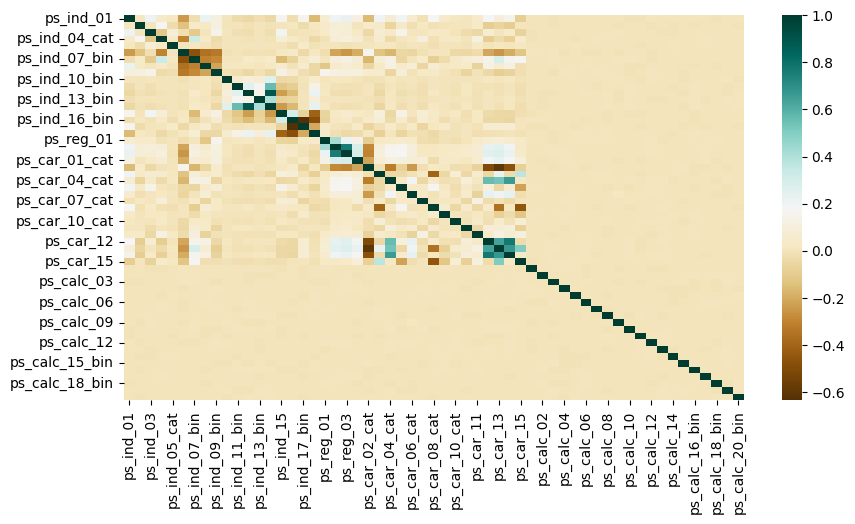

In [12]:
import matplotlib.pyplot as plt

# Find correlating features: 
plt.figure(figsize=(10, 5))
c = X.corr() # Compute pairwise correlation of columns
sns.heatmap(c, cmap='BrBG')

### Model Selection

### Classification 

Classification with scikit's `MLPClassifier`, which implements a multi-layer perceptron algorithm that trains using Backpropagation [[Source]](https://scikit-learn.org/stable/modules/neural_networks_supervised.html).

I'm going to try with both the normalised and the standardised data.

In [48]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train) # Train the classifier 

y_pred = clf.predict(X_test)

### Evaluation

[[23855     0]
 [ 1132     0]]


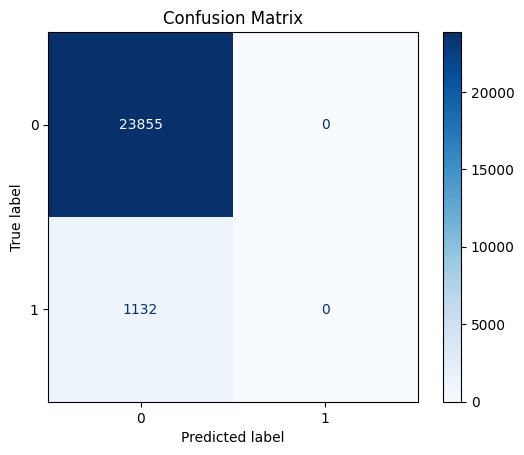

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title("Confusion Matrix")
print(disp.confusion_matrix)

# confusion_matrix(y_test, y_pred)

[imported from old file, use as needed]

## Model Evaluation 

### Evaluation

We can look at the following classification metrics: 

1. Accuracy
2. Precision and Recall
3. F1-Score
4. ROC-AUC (The area under the receiver operating characteristic curve. It shows the capability of a model to distinguish between classes.)

### Validation 

There are different methods to validate the model: 

1. Holdout Method
2. K-Fold Cross-Validation
3. Startified and Time-Series Splits